In [1]:
import math
import matplotlib.pyplot as plt
import pyspark


Also try maximum magnitude of storms for each year, bin them into [0,20], [20,30],[40,50],[50,infty], storm distributions for each year, frequency versus magnitude

In [ ]:
# trending stronger? spearman correlation
# import scipy.stats as st

# years = [x[0] for x in data]
# mags  = [x[1] for x in data]

# rho, p = st.spearmanr(years, mags)

# maximum each year
# max_mag_year = rdd_MAG_clean.reduceByKey(lambda a, b: max(a, b))

# bins for magnitudes
# def band(m):
#     if m < 10: return "0–10"
#     elif m < 20: return "10–20"
#     elif m < 50: return "20–50"
#     elif m < 100: return "50–100"
#     else: return ">100"

# band_counts = (
#     rdd_MAG_clean
#     .map(lambda x: ((x[0], band(x[1])), 1))
#     .reduceByKey(lambda a,b: a+b)
# )



In [2]:
sc = pyspark.SparkContext(appName="StormApp").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/01 14:48:58 WARN Utils: Your hostname, Johns-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 10.41.246.236 instead (on interface en0)
25/12/01 14:48:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/01 14:48:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/01 14:48:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
# NOAA storm data, only data from 2020-2025
rdd = sc.textFile("/Users/johnhutchens/Desktop/DistComp/GroupProject/storm_g2020.csv")

In [4]:
header = rdd.first()
rdd1 = rdd.filter(lambda x: x != header)

In [5]:
rdd1.getNumPartitions()

11

In [6]:
rdd_split = rdd1.map(lambda x: x.split(","))

In [7]:
rdd_split.take(2)

[['202006',
  '24',
  '1620',
  '202006',
  '24',
  '1620',
  '149684.0',
  '902190',
  'GEORGIA',
  '13.0',
  '2020',
  'June',
  'Thunderstorm Wind',
  'C',
  '321',
  'WORTH',
  'TAE',
  '24-JUN-20 16:20:00',
  'EST-5',
  '24-JUN-20 16:20:00',
  '0',
  '0',
  '0',
  '0',
  '0.00K',
  '0.00K',
  '911 Call Center',
  '50.0',
  'EG',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '1.0',
  'W',
  'DOLES',
  '1.0',
  'W',
  'DOLES',
  '31.7',
  '-83.89',
  '31.7',
  '-83.89',
  '"As is typical during summer',
  ' scattered afternoon thunderstorms produced a few instances of damaging winds."',
  '"A power line was blown down on Highway 32W.  Hail was also noted',
  ' but the size was unknown."',
  'CSV'],
 ['202006',
  '20',
  '1930',
  '202006',
  '20',
  '1930',
  '149048.0',
  '898391',
  'KANSAS',
  '20.0',
  '2020',
  'June',
  'Hail',
  'C',
  '137',
  'NORTON',
  'GLD',
  '20-JUN-20 19:30:00',
  'CST-6',
  '20-JUN-20 19:30:00',
  '0',
  '0',
  '0',
  '0',
  '',
  '',
  'Pu

In [ ]:
rdd_MAG = rdd_split.map(lambda x: (x[10],x[27]))

In [9]:
def safe_float(x):
    try:
        return float(x)
    except:
        return float('nan') 

In [10]:
rdd_MAG_num = rdd_MAG.map(lambda x: (int(x[0]),safe_float(x[1])))


In [11]:
rdd_MAG_clean = rdd_MAG_num.filter(lambda x: x[1] != 0 and x[1] != float('nan'))

In [12]:
rdd_MAG_clean = rdd_MAG_clean.filter(lambda x: not math.isnan(x[1]))

In [13]:
rdd_MAG_clean.collect()

[(2020, 50.0),
 (2020, 1.0),
 (2020, 0.75),
 (2020, 52.0),
 (2020, 1.25),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 1.75),
 (2020, 59.0),
 (2020, 50.0),
 (2020, 52.0),
 (2020, 51.0),
 (2020, 56.0),
 (2020, 56.0),
 (2020, 0.75),
 (2020, 51.0),
 (2020, 52.0),
 (2020, 78.0),
 (2020, 56.0),
 (2020, 51.0),
 (2020, 43.0),
 (2020, 54.0),
 (2020, 54.0),
 (2020, 76.0),
 (2020, 53.0),
 (2020, 57.0),
 (2020, 61.0),
 (2020, 56.0),
 (2020, 1.0),
 (2020, 50.0),
 (2020, 0.75),
 (2020, 1.5),
 (2020, 1.75),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 0.88),
 (2020, 1.25),
 (2020, 50.0),
 (2020, 70.0),
 (2020, 52.0),
 (2020, 0.75),
 (2020, 51.0),
 (2020, 61.0),
 (2020, 59.0),
 (2020, 1.75),
 (2020, 1.75),
 (2020, 31.0),
 (2020, 42.0),
 (2020, 56.0),
 (2020, 52.0),
 (2020, 50.0),
 (2020, 50.0),
 (2020, 50.0),
 (2020, 0.88),
 (2020, 2.0),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 0.88),
 (2020, 0.75),
 (2020, 65.0),
 (2020, 50.0),
 (2020, 45.0),
 (2020, 57.0),
 (2020, 56.0),

In [14]:
# average magnitude of storm per year
# where magnitude is the measured extent of the magnitude type 
# ~ only used for wind speeds (in knots) and hail size
# (in inches to the hundredth). 
avg_per_year = (
    rdd_MAG_clean
    .mapValues(lambda v: (v, 1))                               
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))       
    .mapValues(lambda x: x[0] / x[1])                           
)

In [34]:
data_avg = avg_per_year.collect()

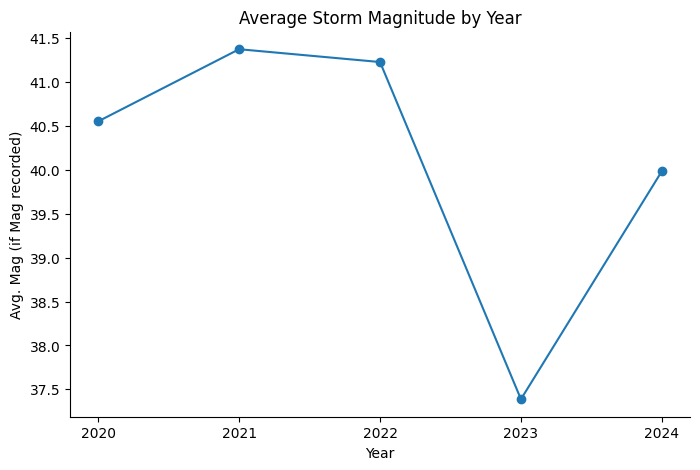

In [36]:
data = [d for d in data_avg if d[0]!= 2025]

# Sort data by year
data_sorted = sorted(data)

years = [x[0] for x in data_sorted]
values = [x[1] for x in data_sorted]

plt.figure(figsize=(8, 5))
plt.plot(years, values, marker='o')
plt.title("Average Storm Magnitude by Year")
plt.xlabel("Year")
plt.xticks(years)
plt.ylabel("Avg. Mag (if Mag recorded)")
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [17]:
# count per year of storms with magnitude over 50
count_over_50 = (
    rdd_MAG_clean
    .filter(lambda x: x[1] > 50)
    .map(lambda x: (x[0], 1))
    .reduceByKey(lambda a, b: a + b)
)

In [29]:
data_raw50 = count_over_50.collect()

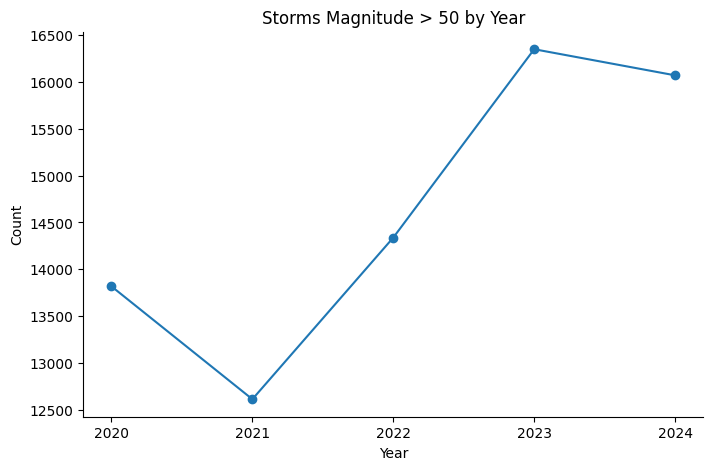

In [33]:
data = [d for d in data_raw50 if d[0]!= 2025]

# Sort data by year
data_sorted = sorted(data)

years = [x[0] for x in data_sorted]
values = [x[1] for x in data_sorted]

plt.figure(figsize=(8, 5))
plt.plot(years, values, marker='o')
plt.title("Storms Magnitude > 50 by Year")
plt.xlabel("Year")
plt.xticks(years)
plt.ylabel("Count")
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [20]:
# count per year of storms with magnitude over 20
count_over_20 = (
    rdd_MAG_clean
    .filter(lambda x: x[1] > 20)
    .map(lambda x: (x[0], 1))
    .reduceByKey(lambda a, b: a + b)
)

In [37]:
data_raw20 = count_over_20.collect()

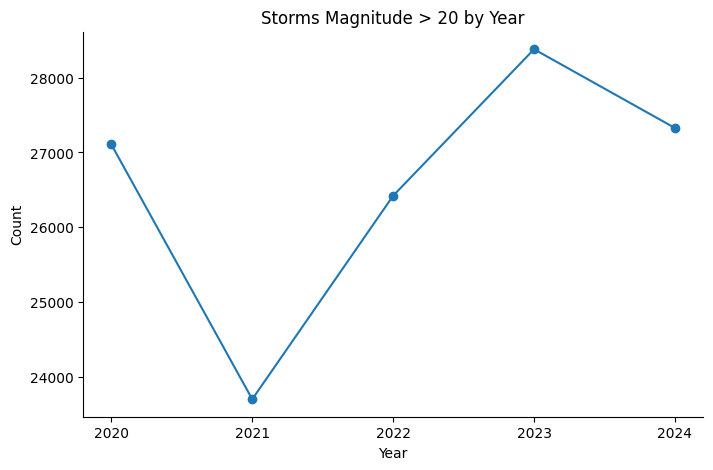

In [38]:
data = [d for d in data_raw20 if d[0] != 2025]

# Sort data by year
data_sorted = sorted(data)

years = [x[0] for x in data_sorted]
values = [x[1] for x in data_sorted]

plt.figure(figsize=(8, 5))
plt.plot(years, values, marker='o')
plt.title("Storms Magnitude > 20 by Year")
plt.xlabel("Year")
plt.xticks(years)
plt.ylabel("Count")
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [14]:
sc.stop()